In [1]:
import os
gpu_num = 0 # 使用 "" 来启用 CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility
import matplotlib.pyplot as plt
import numpy as np
import sionna

# Import Sionna RT components
from mysionna.rt import load_scene, Transmitter, Receiver, PlanarArray
from mysionna.rt.scattering_pattern import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
scene = load_scene("./scenes/Indoor/indoor.xml")
# scene = load_scene(sionna.rt.scene.etoile)

jit_optix_api_init(): libnvoptix.so.1 could not be loaded -- disabling OptiX backend! Set the DRJIT_LIBOPTIX_PATH environment variable to specify its path. One common explanation of this error message could be that you are using the Windows Subsystem for Linux ("WSL"). Note that rendering via the OptiX/CUDA backend is not currently supported on this platform, which is a limitation of OptiX itself. 


RuntimeError: ​[xml.cpp:1079] Error while loading "./scenes/Indoor/indoor.xml" (near line 1, col 1): could not instantiate scene plugin of type "scene": Could not initialize OptiX!

In [ ]:
scene.preview()

In [23]:
#################配置发端天线阵列#################
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

#################配置收端天线阵列#################
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

In [19]:
################创建发射机#########################
tx = Transmitter(name="tx",
                 position=[0,0,2.95])
tx.look_at([1.9,3.2,1.0])
################ 将发射机加入到场景中##############
scene.add(tx)
#################创建接收机########################
rx = Receiver(name="rx",
              position=[0,0,2.95])
rx.look_at([1.9,3.2,1.0])
################ 将接收机加入到场景中##############
scene.add(rx)


In [24]:
scene.frequency = 2.14e9 # in Hz; implicitly updates RadioMaterials
scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

In [25]:
scene.target_names = ["table1"]
scene.target_velocities = [(0,0,0.0)]

In [26]:
p1 = LambertianPattern()
p2 = DirectivePattern(20)
scene.get("itu_plywood").scattering_coefficient = 0.4
scene.get("itu_plywood").scattering_pattern = p2
scene.get("itu_concrete").scattering_coefficient = 0.3
scene.get("itu_concrete").scattering_pattern = p1
scene.get("itu_floorboard").scattering_coefficient = 0.4
scene.get("itu_floorboard").scattering_pattern = p2
scene.get("itu_ceiling_board").scattering_coefficient = 0.4
scene.get("itu_ceiling_board").scattering_pattern = p2

In [27]:
crbs = scene.coverage_map_sensing(map_center=[0,0,2.95],
                                  map_size_x=6,
                                  map_size_y=10,
                                  cell_size=0.5,
                                  look_at=[0,0,0],
                                  batch_size=1,
                                  singleBS=True,
                                  num_samples=1000000,
                                  max_depth=3,
                                  diffraction=True,
                                  edge_diffraction=True,
                                  num_time_steps=1)

Computing cells 0 to 1
Computing cells 1 to 2
Computing cells 2 to 3
Computing cells 3 to 4
Computing cells 4 to 5
Computing cells 5 to 6
Computing cells 6 to 7
Computing cells 7 to 8
Computing cells 8 to 9
Computing cells 9 to 10
Computing cells 10 to 11
Computing cells 11 to 12
Computing cells 12 to 13
Computing cells 13 to 14
Computing cells 14 to 15
Computing cells 15 to 16
Computing cells 16 to 17
Computing cells 17 to 18
Computing cells 18 to 19
Computing cells 19 to 20
Computing cells 20 to 21
Computing cells 21 to 22
Computing cells 22 to 23
Computing cells 23 to 24
Computing cells 24 to 25
Computing cells 25 to 26
Computing cells 26 to 27
Computing cells 27 to 28
Computing cells 28 to 29
Computing cells 29 to 30
Computing cells 30 to 31
Computing cells 31 to 32
Computing cells 32 to 33
Computing cells 33 to 34
Computing cells 34 to 35
Computing cells 35 to 36
Computing cells 36 to 37
Computing cells 37 to 38
Computing cells 38 to 39
Computing cells 39 to 40
Computing cells 40 

/tmp/ipykernel_71478/3387307165.py:14: RuntimeWarning: divide by zero encountered in log10
  crb = np.log10(crb)


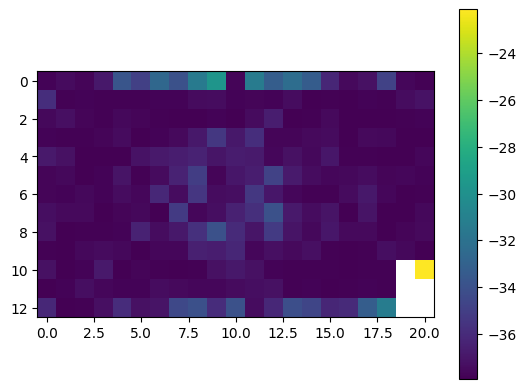

In [28]:
crb = None
for i in range(0,len(crbs)):
    c = crbs[i][0]
    c = tf.squeeze(c)
    # c = tf.linalg.diag_part(c)
    c = c.numpy()
    if crb is None:
        crb = c
    else:
        crb = np.concatenate((crb,c),axis=None)
crb = np.array(crb)
crb = np.reshape(crb,[-1,21])
np.save("./Data/indoor/table1/crb.npy",crb)
crb = np.log10(crb)
plt.imshow(crb)
plt.colorbar()


In [8]:
paths = scene.compute_paths(max_depth=3,diffraction=True,scattering=True,edge_diffraction=True)

In [11]:
# scene.preview(paths=paths)

In [9]:
v,obj=scene.compute_target_velocities(paths, return_obj_names=True)

In [10]:
subcarrier_spacing = 15e3
num_time_steps = 1
paths.apply_doppler(sampling_frequency=subcarrier_spacing, num_time_steps=num_time_steps,target_velocities=v)

In [11]:
crb = paths.crb_delay()

In [12]:
paths.export_crb(crb,"test.xyzrgb",BS_pos = [0,0,2.95])

True

/tmp/ipykernel_18672/437392773.py:12: RuntimeWarning: divide by zero encountered in log10
  crb = np.log10(crb)
/tmp/ipykernel_18672/437392773.py:32: RuntimeWarning: divide by zero encountered in log10
  mse = np.log10(mse)


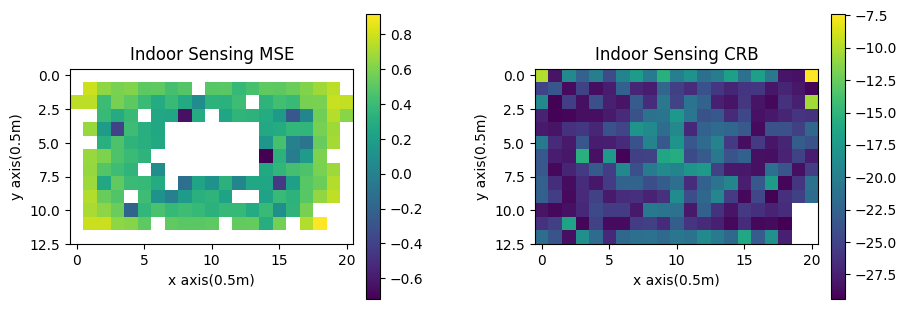

In [23]:
scene_name = "indoor"
target = "table1"

with open(f"./Data/{scene_name}/{target}/1000000_6_10_0.5_tau_true.txt","r") as f:
    tau_true = f.readlines()
    tau_true = np.array([float(i) for i in tau_true])
with open(f"./Data/{scene_name}/{target}/1000000_6_10_0.5_tau_est.txt","r") as f:
    tau_est = f.readlines()
    tau_est = np.array([float(i) for i in tau_est])
crb = np.load(f"./Data/{scene_name}/{target}/crb.npy")
crb = crb*3e8
crb = np.log10(crb)
crb = np.reshape(crb,(-1,21))

pad = 0

mse = np.abs(tau_true-tau_est)
mse = np.reshape(mse,(-1,21))
tau_true = np.reshape(tau_true,(-1,21))
tau_est = np.reshape(tau_est,(-1,21))
mask = mse >= 1
mse[mask] = pad
mask = tau_est==0
mse[mask] = pad
mask = tau_true==999999 
mse[mask] = pad
mask = tau_true==0
mse[mask] = pad
mask = tau_true==-1
mse[mask] = pad
mse = mse*3e8
mse = np.log10(mse)
# set figure size
plt.figure(figsize=(10, 5))
plt.subplots_adjust(wspace=0.5)
plt.subplot(121)
plt.title("Indoor Sensing MSE")
plt.xlabel("x axis(0.5m)")
plt.ylabel("y axis(0.5m)")
plt.imshow(mse)
# set colorbar size
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(122)
plt.title("Indoor Sensing CRB")
plt.xlabel("x axis(0.5m)")
plt.ylabel("y axis(0.5m)")
plt.imshow(crb)
plt.colorbar(fraction=0.046, pad=0.04)
plt.savefig(f"./Data/{scene_name}/{target}/out.png")

In [6]:
np.argmin(mse)

227